In [1]:
from qiskit import *

In [3]:
#creating a 3 qubit circuit
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure([0,1,2], [0,1,2])

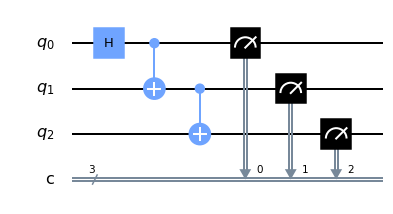

In [4]:
%matplotlib inline
circuit.draw(output='mpl')

In [5]:
#runnin on the quantum simulator (no noise)
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend = simulator, shots=1024).result()

In [6]:
from qiskit.visualization import plot_histogram

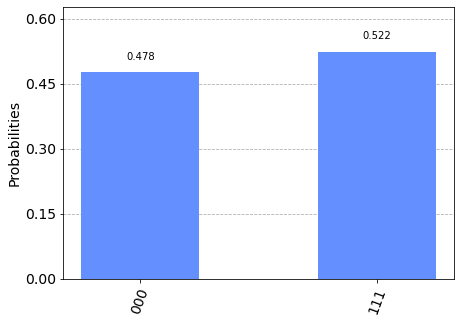

In [7]:
plot_histogram(sim_result.get_counts(circuit))

In [10]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmqx2')

C:\Users\Rapha\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [11]:
#running on real quantum computer (we get noise here)
job = execute(circuit, backend = device, shots=1024)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

5f899eac77d4ec0012afbbf0
Job Status: job has successfully run


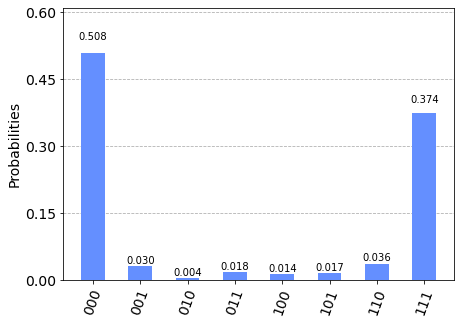

In [14]:
device_result = job.result()
plot_histogram(device_result.get_counts())

In [15]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [20]:
#getting calibration circuit for a 3 qubit quantum circuit
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerromitigaationcal')

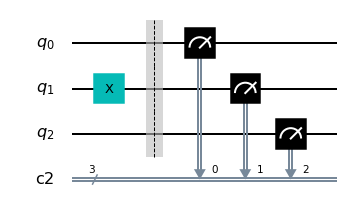

In [23]:
cal_circuits[2].draw(output='mpl')

In [24]:
len(cal_circuits) #this is 8 since I have 3 qubits (2^3=8)

8

In [ ]:
#execute the calibration circuits on a real quantum computer
cal_job = execute(cal_circuits,
                 backend = device,
                 shots = 1024,
                 optimization_level = 0
                 )
print(cal_job.job_id())
job_monitor(cal_job)

In [26]:
cal_results = cal_job.result()

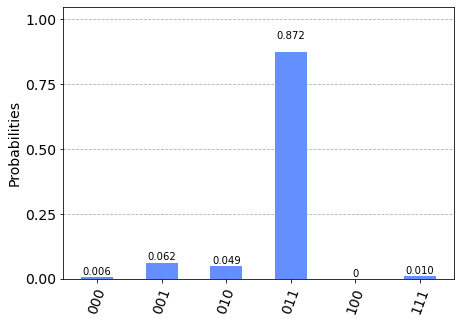

In [27]:
plot_histogram(
cal_results.get_counts(cal_circuits[3])
)

In [28]:
#creating the fitter and using the calibration results that we then use to create the results filter
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

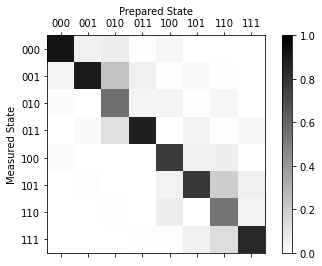

In [29]:
meas_fitter.plot_calibration()

In [31]:
meas_filter = meas_fitter.filter

In [32]:
#filtering the previous results that we want to mitigate
mitigated_result = meas_filter.apply(device_result)

In [33]:
device_counts = device_result.get_counts(circuit)

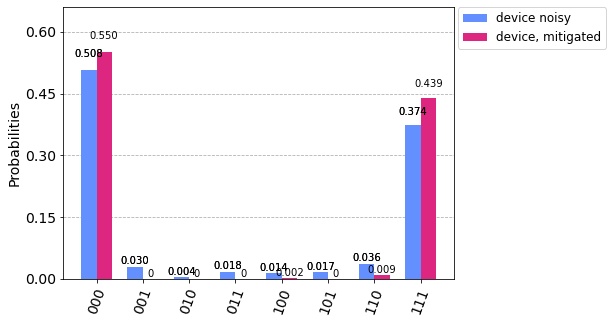

In [43]:
mitigated_counts = mitigated_result.get_counts(circuit)
#comparing before and after mitigation
plot_histogram([device_counts,mitigated_counts], legend=['device noisy', 'device, mitigated'])

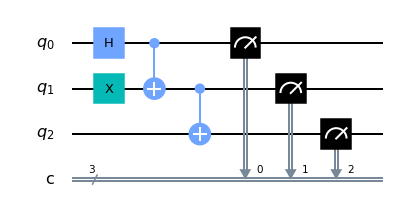

In [36]:
#Now we build a completely different 3 qubit circuit to run the same filter on
circuit2 = QuantumCircuit(3,3)
circuit2.x(1)
circuit2.h(0)
circuit2.cx(0,1)
circuit2.cx(1,2)
circuit2.measure([0,1,2],[0,1,2])
circuit2.draw(output='mpl')

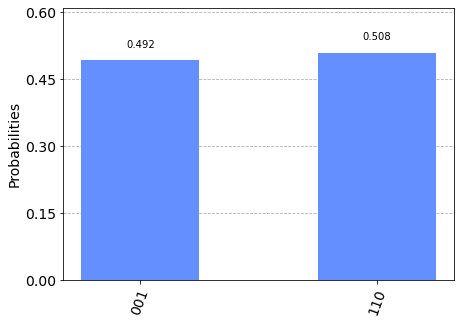

In [38]:
#run it on the simulator without any noise
plot_histogram(
    execute(circuit2, backend=simulator, shots=1024).result().get_counts(circuit2)
)

In [ ]:
#run it on a real quantum computer
device_counts_2=execute(circuit2, backend=device, shots = 1024).result().get_counts(circuit2)

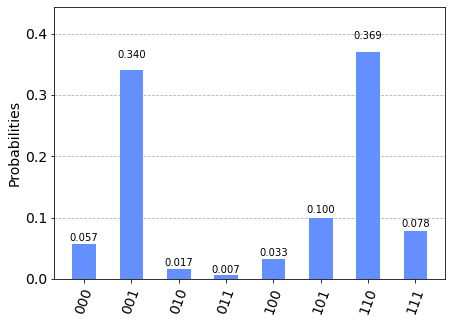

In [40]:
plot_histogram(device_counts_2)

In [41]:
#mitigating previous results using the same 3 qubit filter
device_mitigated_counts_2 = meas_filter.apply(device_counts_2)

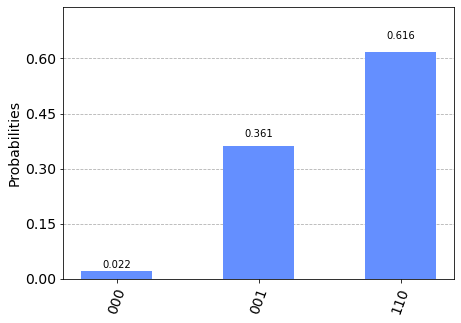

In [42]:
plot_histogram(device_mitigated_counts_2)